# Twitter Detection Suicide

In [1]:
# Librairies to install
!pip install vaderSentiment
!pip install textblob
!pip install happytransformer
!pip install transformers

In [12]:
# Important librairy
import pandas as pd
import numpy as np
import nltk
import os
import re
import warnings
warnings.filterwarnings('ignore')

# For Modele
nltk.download('sentiwordnet')
from nltk.tag import UnigramTagger
from nltk.corpus import treebank
from nltk.tokenize import word_tokenize
from nltk.corpus import sentiwordnet as swn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from happytransformer import HappyTextClassification
from transformers import AutoModel, AutoTokenizer
from transformers import pipeline

# Analyse des données
import seaborn as sn
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\owen9\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


AttributeError: module 'tensorflow.core.framework.types_pb2' has no attribute 'SerializedDType'

In [13]:
# On charge les deux dataset de test et de train
#df = pd.read_csv('./Suicide_Detection_Reddit2.csv')
df = pd.read_csv('./Suicide_Detection_Tweeter.csv')
#df = pd.read_csv(r'C:\Users\owen9\OneDrive\Documents\GitHub\TwitterFeelingAnalyse\Dataset\Suicide_Detection_Tweeter.csv')
df = df.rename(columns={
    "Tweet": "text",
    "Suicide": "class"
})
df["text"] = df["text"].astype(str)
df["class"] = df["class"].astype(str)
df.head(10)

FileNotFoundError: [Errno 2] No such file or directory: './Suicide_Detection_Tweeter.csv'

In [4]:
# On affiche la dimension du dataset
print('Nombre de ligne : ' +  str(df.shape[0]))
print('Nombre de colonne : ' + str(df.shape[1]))

Nombre de ligne : 1599
Nombre de colonne : 2


# Cleaning

In [8]:
def Cleaning(Text):
    #supprimer les identifiactions avec les @
    L=[]#liste des mots à enlever
    for i in range(len(Text)):
        if Text[i]=='@':            
            s=''
            for j in Text[i:]:
                if j != ' ':
                    s+=j
                else:
                    break            
            L.append(s)
    #suppression de tous les mots
    for word in L:
        Text=Text.replace(word,'')
    
    #On garde que les caractères alphanumériques
    Text=re.sub(r'((?![a-z]|[A-Z]|\d).)',' ',Text)#((?!...).) => opposé
    
    return Text.strip() #suppression des espaces au début et à la fin

In [6]:
df['text'] = df['text'].apply(lambda x: Cleaning(x))
df.head(10)

,text,class
0,i hate myself so much i want to KILL myself ho...,Potential Suicide post
1,RT I woke up with a bag over my head after I ...,Potential Suicide post
2,i wanna fucking kill myself,Potential Suicide post
3,why do i destroy all my opportunities am i go...,Potential Suicide post
4,u understand what the fuck im doing wrong wi...,Potential Suicide post
5,Wait I take this back I fucking hate living i...,Potential Suicide post
6,Bitch I m gonna kill myself what the fuck,Potential Suicide post
7,goodnight i really want to fucking kill myself,Potential Suicide post
8,I wanna kill myself like not literally but men...,Potential Suicide post
9,its crazy cause i shut myself out on two ppl i...,Potential Suicide post


# Modeles

## Fonction Globale

In [9]:
# Instanciez le modèle et le tokeniseur
def Classificator(name):
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModel.from_pretrained(name)
    return pipeline(model=name)

In [10]:
# Keyword Analyse
train_sents = treebank.tagged_sents()[:3000]
tagger = UnigramTagger(train_sents)

# Classificateur
happy_tc = HappyTextClassification(model_type="DISTILBERT", model_name="distilbert-base-uncased-finetuned-sst-2-english", num_labels=2)
classifier_bert = Classificator("nlptown/bert-base-multilingual-uncased-sentiment")
classifier_suicidal_bert = Classificator("gooohjy/suicidal-bert")

NameError: name 'HappyTextClassification' is not defined

In [9]:
def AddModeleIntoDataframe(df, function_modele, list_column_name):
    df[list_column_name] = df['text'].apply(lambda x: function_modele(x))
    return df

In [10]:
def AddAllModelToDF(df):
    #cleaning du dataframe
    df["text"] = df["text"].apply(lambda x: x[:500])
    
    print("Réalisation de la fonction keyword_analyse en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_keyword, "keyword_label")
    
    print("Réalisation de la fonction sentiment_vader en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_vader, "valder_label")
    
    print("Réalisation de la fonction sentiment_texblob en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_texblob_polarity, "textbloc_polarity_label")
    df = AddModeleIntoDataframe(df, sentiment_texblob_subjectivity, "textbloc_subjectivity_label")
    
    print("Réalisation de la fonction sentiment_happy_transformer en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_happy_transformer, "happy_transformer_label")
    
    print("Réalisation de la fonction sentiment_bert en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_bert, "bert_label")
    
    print("Réalisation de la fonction sentiment_suicidal_bert en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_suicidal_bert, "suicidal_bert_label")

    return df

## KeyWord Analyse

In [11]:
train_sents = treebank.tagged_sents()[:3000]
tagger = UnigramTagger(train_sents)
      
def sentiment_keyword(text):
    L=set()
    texte=word_tokenize(text)
    tag=tagger.tag(texte)

    for t in tag:
        L.add(t[0])

    pos_score=0
    neg_score=0

    for adv in L:
        adv_senti = list(swn.senti_synsets(adv))
        if len(adv_senti)!=0:
            pos_score+=adv_senti[0].pos_score()
            neg_score+=adv_senti[0].neg_score()
    
    res='Negative'
    if pos_score > neg_score:
        res='Positive'

    return res

## Valder

In [12]:
def sentiment_vader(sentence):
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']

    if sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"
        
    elif sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"   

    else :
        overall_sentiment = "Neutral"
  
    return overall_sentiment

## TextBlob

In [13]:
def sentiment_texblob_polarity(row):
    classifier = TextBlob(row)
    polarity = classifier.sentiment.polarity
    return polarity

def sentiment_texblob_subjectivity(row):
    classifier = TextBlob(row)
    subjectivity = classifier.sentiment.subjectivity
    return subjectivity

## Happy Transformer

In [14]:
def sentiment_happy_transformer(row):
    result = happy_tc.classify_text(row)
    return str(result.label)

## BERT

In [15]:
def sentiment_bert(row):
    # On recupere le sentiment
    res = classifier_bert(row)

    # Ajoutez les résultats aux tableaux
    return res[0]['label'][:1]

## Suicidal BERT

In [16]:
def sentiment_suicidal_bert(row):
    # On recupere le sentiment
    res = classifier_suicidal_bert(row)

    # Ajoutez les résultats aux tableaux
    return res[0]['label']

In [17]:
df.head()

,text,class
0,i hate myself so much i want to KILL myself ho...,Potential Suicide post
1,RT I woke up with a bag over my head after I ...,Potential Suicide post
2,i wanna fucking kill myself,Potential Suicide post
3,why do i destroy all my opportunities am i go...,Potential Suicide post
4,u understand what the fuck im doing wrong wi...,Potential Suicide post


# Analyse

In [31]:
def PreparationModel(df):
    df["class"] = df["class"].replace({"Potential Suicide post ": 1, "Not Suicide post": 0})
    df["keyword_label"] = df["keyword_label"].replace({"Negative": 1, "Positive": 0})
    df["valder_label"] = df["valder_label"].replace({"Negative": 1, "Positive": 0, "Neutral": 0})
    df["happy_transformer_label"] = df["happy_transformer_label"].replace({"NEGATIVE": 1, "POSITIVE": 0})
    df["bert_label"] = df["bert_label"].replace({"1": 1, "2": 0, "3": 0, "4": 0, "5": 0})
    df["suicidal_bert_label"] = df["suicidal_bert_label"].replace({"LABEL_1": 1, "LABEL_0": 0})
    
    df["polarity_modele"] = np.where(df["textbloc_polarity_label"] < -0.5, 0, 1)
    df.copy().drop(['polarity_modele'], axis = 1)
    
    return df

In [35]:
df = AddAllModelToDF(df)
df = PreparationModel(df)
df.head()

,text,class,keyword_label,valder_label,textbloc_polarity_label,textbloc_subjectivity_label,happy_transformer_label,bert_label,suicidal_bert_label,polarity_modele,...,groupement_all_modele_par_4_subjectivity50,groupement_all_modele_par_4_subjectivity75,groupement_all_modele_par_5_subjectivity50,groupement_all_modele_par_5_subjectivity75,groupement_best_modele_par_2,groupement_best_modele_par_3,groupement_best_modele_par_2_subjectivity50,groupement_best_modele_par_2_subjectivity75,groupement_best_modele_par_3_subjectivity50,groupement_best_modele_par_4_subjectivity75
0,i hate myself so much i want to KILL myself ho...,1,1,1,-0.300000,0.550000,1,1,0,1,...,0,0,0,0,1,1,1,0,1,0
1,RT I woke up with a bag over my head after I ...,1,0,0,-0.166667,0.166667,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0
2,i wanna fucking kill myself,1,1,1,-0.600000,0.800000,1,1,0,0,...,0,0,0,0,1,1,1,1,1,1
3,why do i destroy all my opportunities am i go...,1,1,1,-0.228125,0.571875,1,1,0,1,...,0,0,0,0,1,1,1,0,1,0
4,u understand what the fuck im doing wrong wi...,1,1,1,-0.450000,0.750000,1,1,0,1,...,0,0,0,0,1,1,1,1,1,1


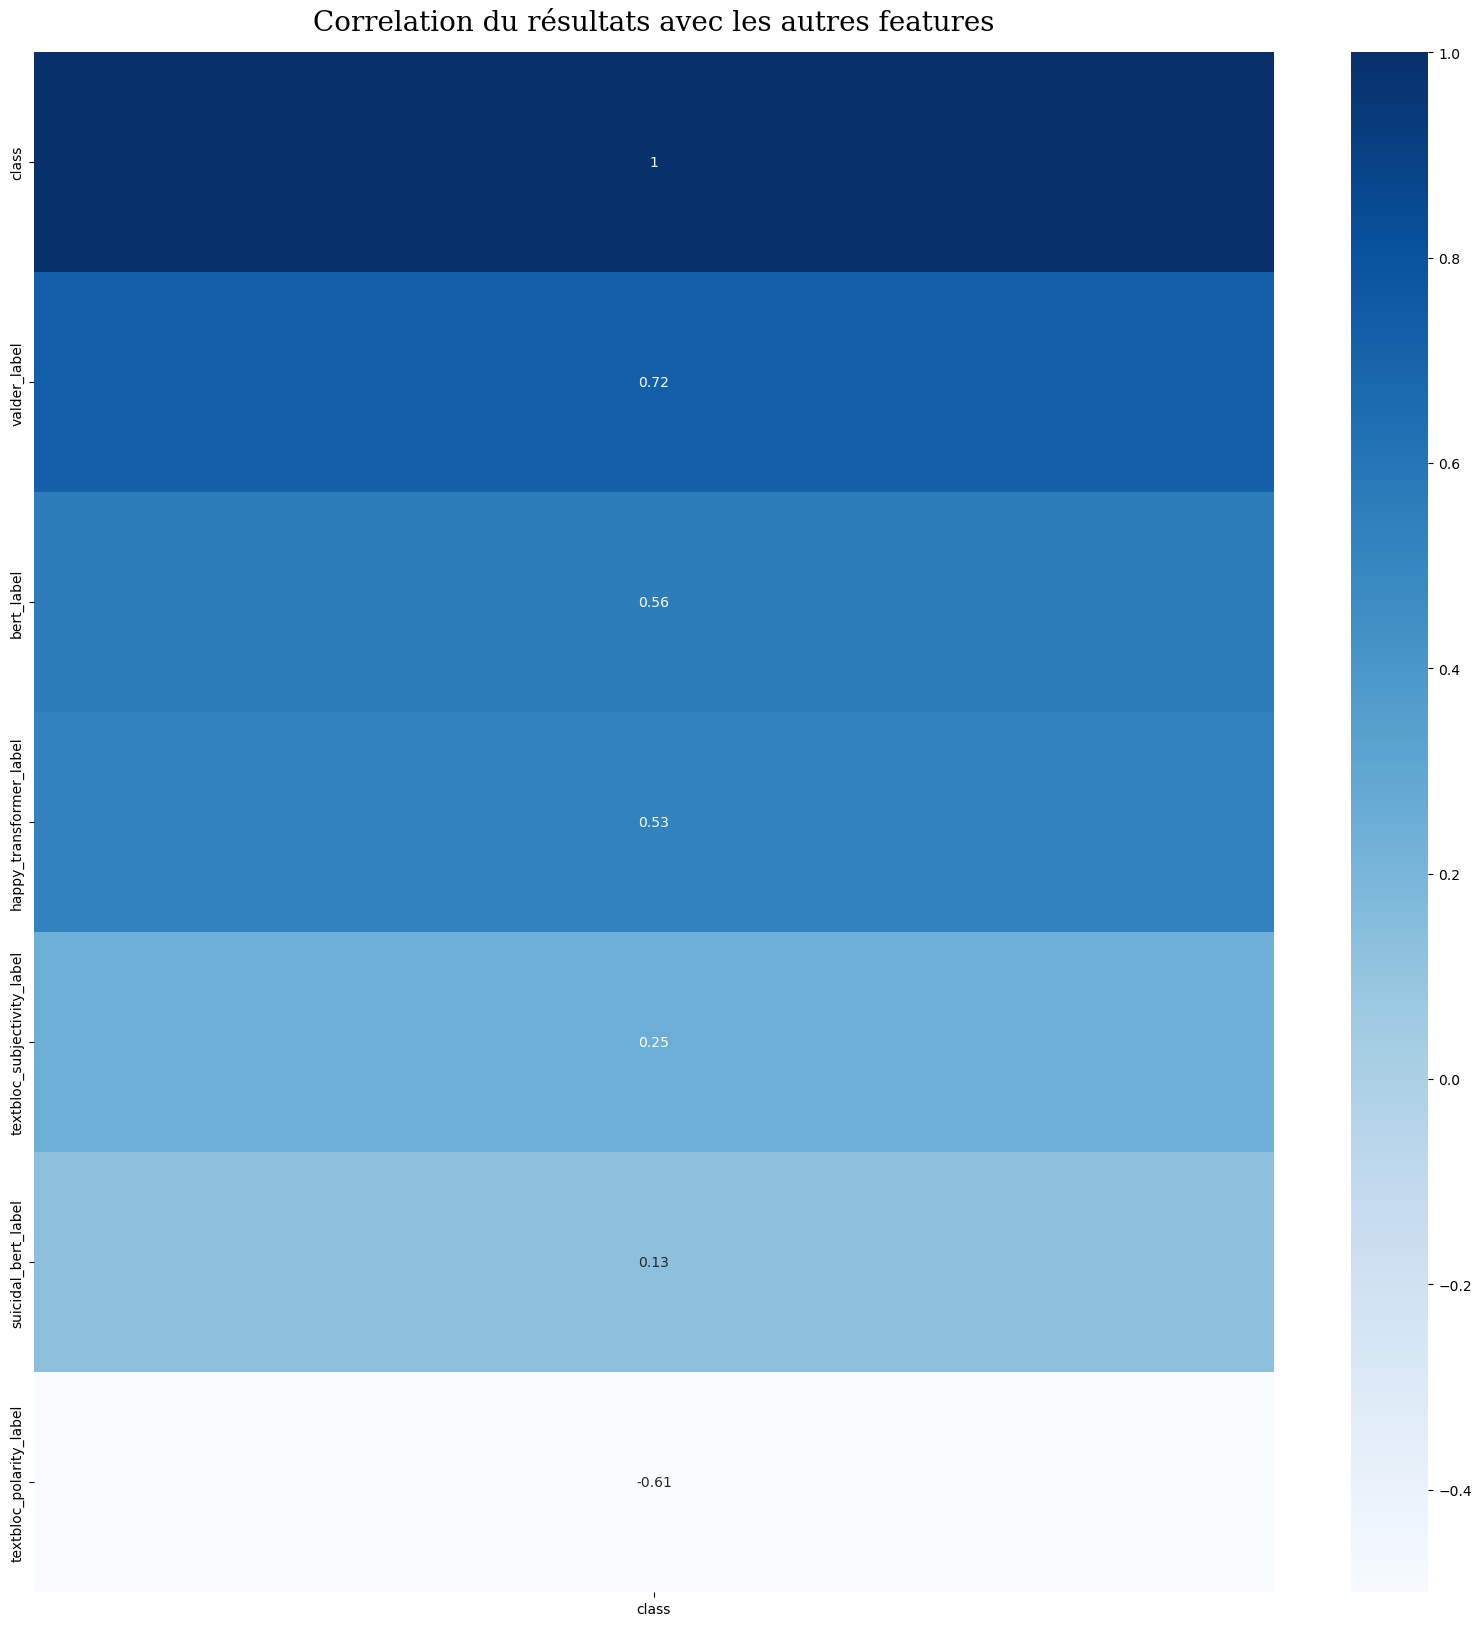

In [20]:
# Nous allons nous concentrez uniquement sur la caractéristique cible
plt.figure(figsize=(20,20))
heatmap = sn.heatmap(df.corr()[['class']].sort_values(by='class', ascending=False), vmin=-0.5, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation du résultats avec les autres features', pad=16, fontdict={'family': 'serif','size': 20});

In [21]:
#df.to_csv(r'C:\Users\owen9\OneDrive\Documents\GitHub\TwitterFeelingAnalyse\Dataset\Resultats_Owen.csv', sep=';', index=False)
df.to_csv('./Suicide_Detection_Tweeter_Final.csv', index=False, sep=';')
#df.to_csv('./Suicide_Detection_Reddit_Final.csv', index=False, sep=';')

# Groupement de modèles

In [22]:
df = pd.read_csv('./Suicide_Detection_Tweeter_Final.csv',sep=';')
# df = pd.read_csv('./Suicide_Detection_Reddit_Final.csv')

In [23]:
def SelectionTweetSuicidaire(df):
    #Methode Naif
    df['Naif'] = 1
    
    # On groupes les 5 modèles que nous avons compilé
    df["modele_groupement_score"] = df[['keyword_label', 'valder_label', 'happy_transformer_label', 'bert_label', 'suicidal_bert_label']].sum(axis=1)
    
    # Methode ou l'on utilise tout les modèles
    # On rajoute certain modele par groupement
    df["groupement_all_modele_par_3"] = np.where(df["modele_groupement_score"] >= 3, 1, 0)
    df["groupement_all_modele_par_4"] = np.where(df["modele_groupement_score"] >= 4, 1, 0)
    df["groupement_all_modele_par_5"] = np.where(df["modele_groupement_score"] >= 5, 1, 0)
    
    # On ajoute la notion de subjectivité
    df["groupement_all_modele_par_4_subjectivity50"] = np.where((df["modele_groupement_score"] >= 4) & (df["textbloc_subjectivity_label"] >= 0.5), 1, 0)
    df["groupement_all_modele_par_4_subjectivity75"] = np.where((df["modele_groupement_score"] >= 4) & (df["textbloc_subjectivity_label"] >= 0.75), 1, 0)
    df["groupement_all_modele_par_5_subjectivity50"] = np.where((df["modele_groupement_score"] >= 5) & (df["textbloc_subjectivity_label"] >= 0.5), 1, 0)
    df["groupement_all_modele_par_5_subjectivity75"] = np.where((df["modele_groupement_score"] >= 5) & (df["textbloc_subjectivity_label"] >= 0.75), 1, 0)

    # Méthodes ou on garde que les modèles les plus coréllé
    # On groupes les 3 modèles que nous avons compilé
    df["modele_groupement_score"] = df[['valder_label', 'happy_transformer_label', 'bert_label']].sum(axis=1)
    
    # On rajoute certain modele par groupement
    df["groupement_best_modele_par_2"] = np.where(df["modele_groupement_score"] >= 2, 1, 0)
    df["groupement_best_modele_par_3"] = np.where(df["modele_groupement_score"] >= 3, 1, 0)

    # On ajoute la notion de subjectivité
    df["groupement_best_modele_par_2_subjectivity50"] = np.where((df["modele_groupement_score"] >= 2) & (df["textbloc_subjectivity_label"] >= 0.5), 1, 0)
    df["groupement_best_modele_par_2_subjectivity75"] = np.where((df["modele_groupement_score"] >= 2) & (df["textbloc_subjectivity_label"] >= 0.75), 1, 0)
    df["groupement_best_modele_par_3_subjectivity50"] = np.where((df["modele_groupement_score"] >= 3) & (df["textbloc_subjectivity_label"] >= 0.5), 1, 0)
    df["groupement_best_modele_par_4_subjectivity75"] = np.where((df["modele_groupement_score"] >= 3) & (df["textbloc_subjectivity_label"] >= 0.75), 1, 0)
    
    #On supprime la colonne temporaire
    df.copy().drop(['modele_groupement_score'], axis = 1)
    
    return df
    
#On execute puis on affiche le resultat
df = SelectionTweetSuicidaire(df.copy())

In [24]:
df.to_csv('./Suicide_Detection_Tweeter_Final.csv', index=False, sep=';')

# Recherche du meilleur modèle

In [19]:
df_init = pd.read_csv('./Suicide_Detection_Tweeter_Final.csv',sep=';')
#df_init=pd.read_csv(r'C:\Users\owen9\OneDrive\Documents\GitHub\TwitterFeelingAnalyse\Dataset\Suicide_Detection_Tweeter_Final.csv',sep=';')
df=df_init.copy()
df.head()

,text,class,keyword_label,valder_label,textbloc_polarity_label,textbloc_subjectivity_label,happy_transformer_label,bert_label,suicidal_bert_label,polarity_modele,...,groupement_all_modele_par_4_subjectivity50,groupement_all_modele_par_4_subjectivity75,groupement_all_modele_par_5_subjectivity50,groupement_all_modele_par_5_subjectivity75,groupement_best_modele_par_2,groupement_best_modele_par_3,groupement_best_modele_par_2_subjectivity50,groupement_best_modele_par_2_subjectivity75,groupement_best_modele_par_3_subjectivity50,groupement_best_modele_par_4_subjectivity75
0,i hate myself so much i want to KILL myself ho...,1,Negatif,1,-0.300000,0.550000,1,1,0,Positif,...,0,0,0,0,1,1,1,0,1,0
1,RT I woke up with a bag over my head after I ...,1,0,0,-0.166667,0.166667,1,1,1,Positif,...,0,0,0,0,1,0,0,0,0,0
2,i wanna fucking kill myself,1,Negatif,1,-0.600000,0.800000,1,1,0,Negatif,...,0,0,0,0,1,1,1,1,1,1
3,why do i destroy all my opportunities am i go...,1,Negatif,1,-0.228125,0.571875,1,1,0,Positif,...,0,0,0,0,1,1,1,0,1,0
4,u understand what the fuck im doing wrong wi...,1,Negatif,1,-0.450000,0.750000,1,1,0,Positif,...,0,0,0,0,1,1,1,1,1,1


In [117]:
#Création des matrices de confusions de chaque modèles
def Matrices(df):
    L_modeles=[m for m in df.columns if (m!='text' and m!='class' and m!='textbloc_polarity_label' 
                                         and m!='textbloc_subjectivity_label' and m!='modele_groupement_score')]

    L_matrices=[]
    
    for m in L_modeles:
        matrice_conf=confusion_matrix(y_true=df['class'], y_pred=df[m])
        matrice_conf=(matrice_conf/(np.sum(matrice_conf)))*100
        L_matrices.append(matrice_conf)
        faux_pos=matrice_conf[0][1]
        L_faux_pos.append(faux_pos)
        
    return L_modeles, L_matrices

In [118]:
L_modeles, L_matrices = Matrices(df)
L_matrices

[array([[42.0888055 , 22.88930582],
        [14.07129456, 20.95059412]]),
 array([[59.47467167,  5.50343965],
        [ 7.12945591, 27.89243277]]),
 array([[40.08755472, 24.8905566 ],
        [ 2.43902439, 32.58286429]]),
 array([[51.71982489, 13.25828643],
        [ 7.87992495, 27.14196373]]),
 array([[64.04002502,  0.9380863 ],
        [32.83302064,  2.18886804]]),
 array([[ 0.68792996, 64.29018136],
        [ 6.62914321, 28.39274547]]),
 array([[ 0.        , 64.97811132],
        [ 0.        , 35.02188868]]),
 array([[62.35146967,  2.62664165],
        [11.63227017, 23.38961851]]),
 array([[6.49155722e+01, 6.25390869e-02],
        [3.37085679e+01, 1.31332083e+00]]),
 array([[64.97811132,  0.        ],
        [35.02188868,  0.        ]]),
 array([[6.49155722e+01, 6.25390869e-02],
        [3.42714196e+01, 7.50469043e-01]]),
 array([[64.97811132,  0.        ],
        [34.64665416,  0.37523452]]),
 array([[64.97811132,  0.        ],
        [35.02188868,  0.        ]]),
 array([[64.97

Toutes ces matrices ne sont pas très parlantes

On vas se concentrer sur 2 valeurs:

-d'abord les faux positifs qu'on souhaite minimiser, car on ne veut pas prévenir des personnes pour rien, il faut que notre bot reste crédible

-les faux négatifs ensuite, car des modèles peuvent avoir très peu de faux positifs en pronostiquant en grande majorité un message non suicidaire, au risque de rater trop de messages à risque.

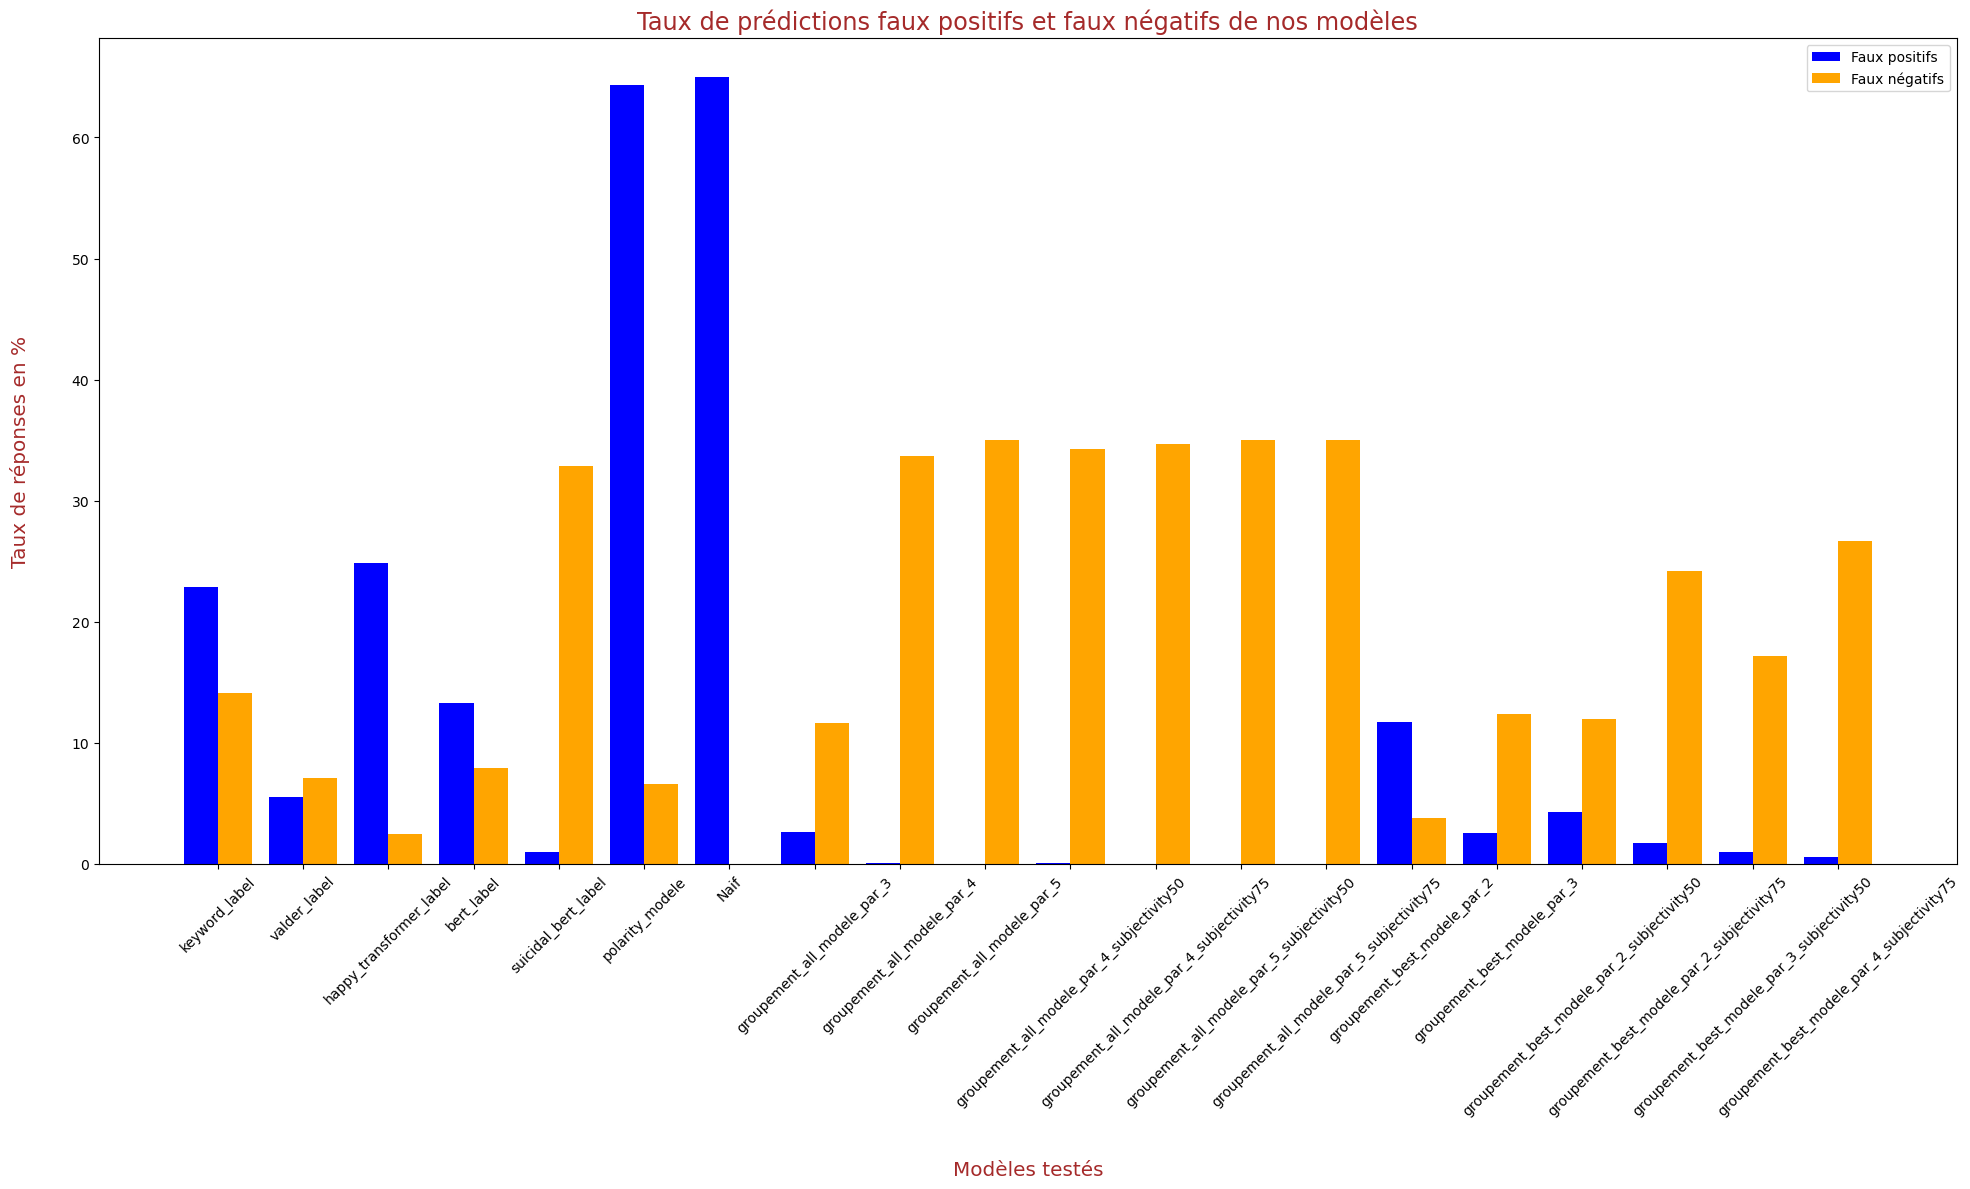

In [160]:
# Data
L_faux_pos=[m[0][1] for m in L_matrices]
L_faux_neg=[m[1][0] for m in L_matrices]

# Create a new figure with specific size
fig = plt.figure(figsize=(20, 12))

# Create the first bar chart
plt.bar(L_modeles, L_faux_pos, width=-0.4, align='edge', color='b')

# Create the second bar chart
plt.bar(L_modeles, L_faux_neg, width=0.4, align='edge', color='orange')

# Add the legend
plt.legend(('Faux positifs', 'Faux négatifs'))
plt.xlabel('Modèles testés', size='x-large',color='brown', labelpad=30)
plt.ylabel('Taux de réponses en %', size='x-large', color='brown',labelpad=30)
plt.title('Taux de prédictions faux positifs et faux négatifs de nos modèles', size='xx-large', color='brown')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
#plt.savefig('graph_resultats_modeles.png')
plt.show()



Comme prévu on peut pas s'appuyer que sur le taux de faux positifs, car plusieurs modèles obtenant aucun faux positifs ont au contraire un taux élevé de faux négatifs (>30%), ratant donc beaucoup de messages sensibles.

In [161]:
#Affiner en récupérant les modèles avec un taux maximum pour les faux positifs et faux négatifs
def Affinage(score_max):

    L_modeles2=[]
    L_matrices2=[]
    L_faux_pos2=[]
    L_faux_neg2=[]

    for i in range(len(L_modeles)):
        if L_faux_pos[i] < score_max and L_faux_neg[i] < score_max:
            L_modeles2.append(L_modeles[i])
            L_matrices2.append(L_matrices[i])
            L_faux_pos2.append(L_faux_pos[i])
            L_faux_neg2.append(L_faux_neg[i])
    
    return L_modeles2,L_matrices2,L_faux_pos2,L_faux_neg2
        

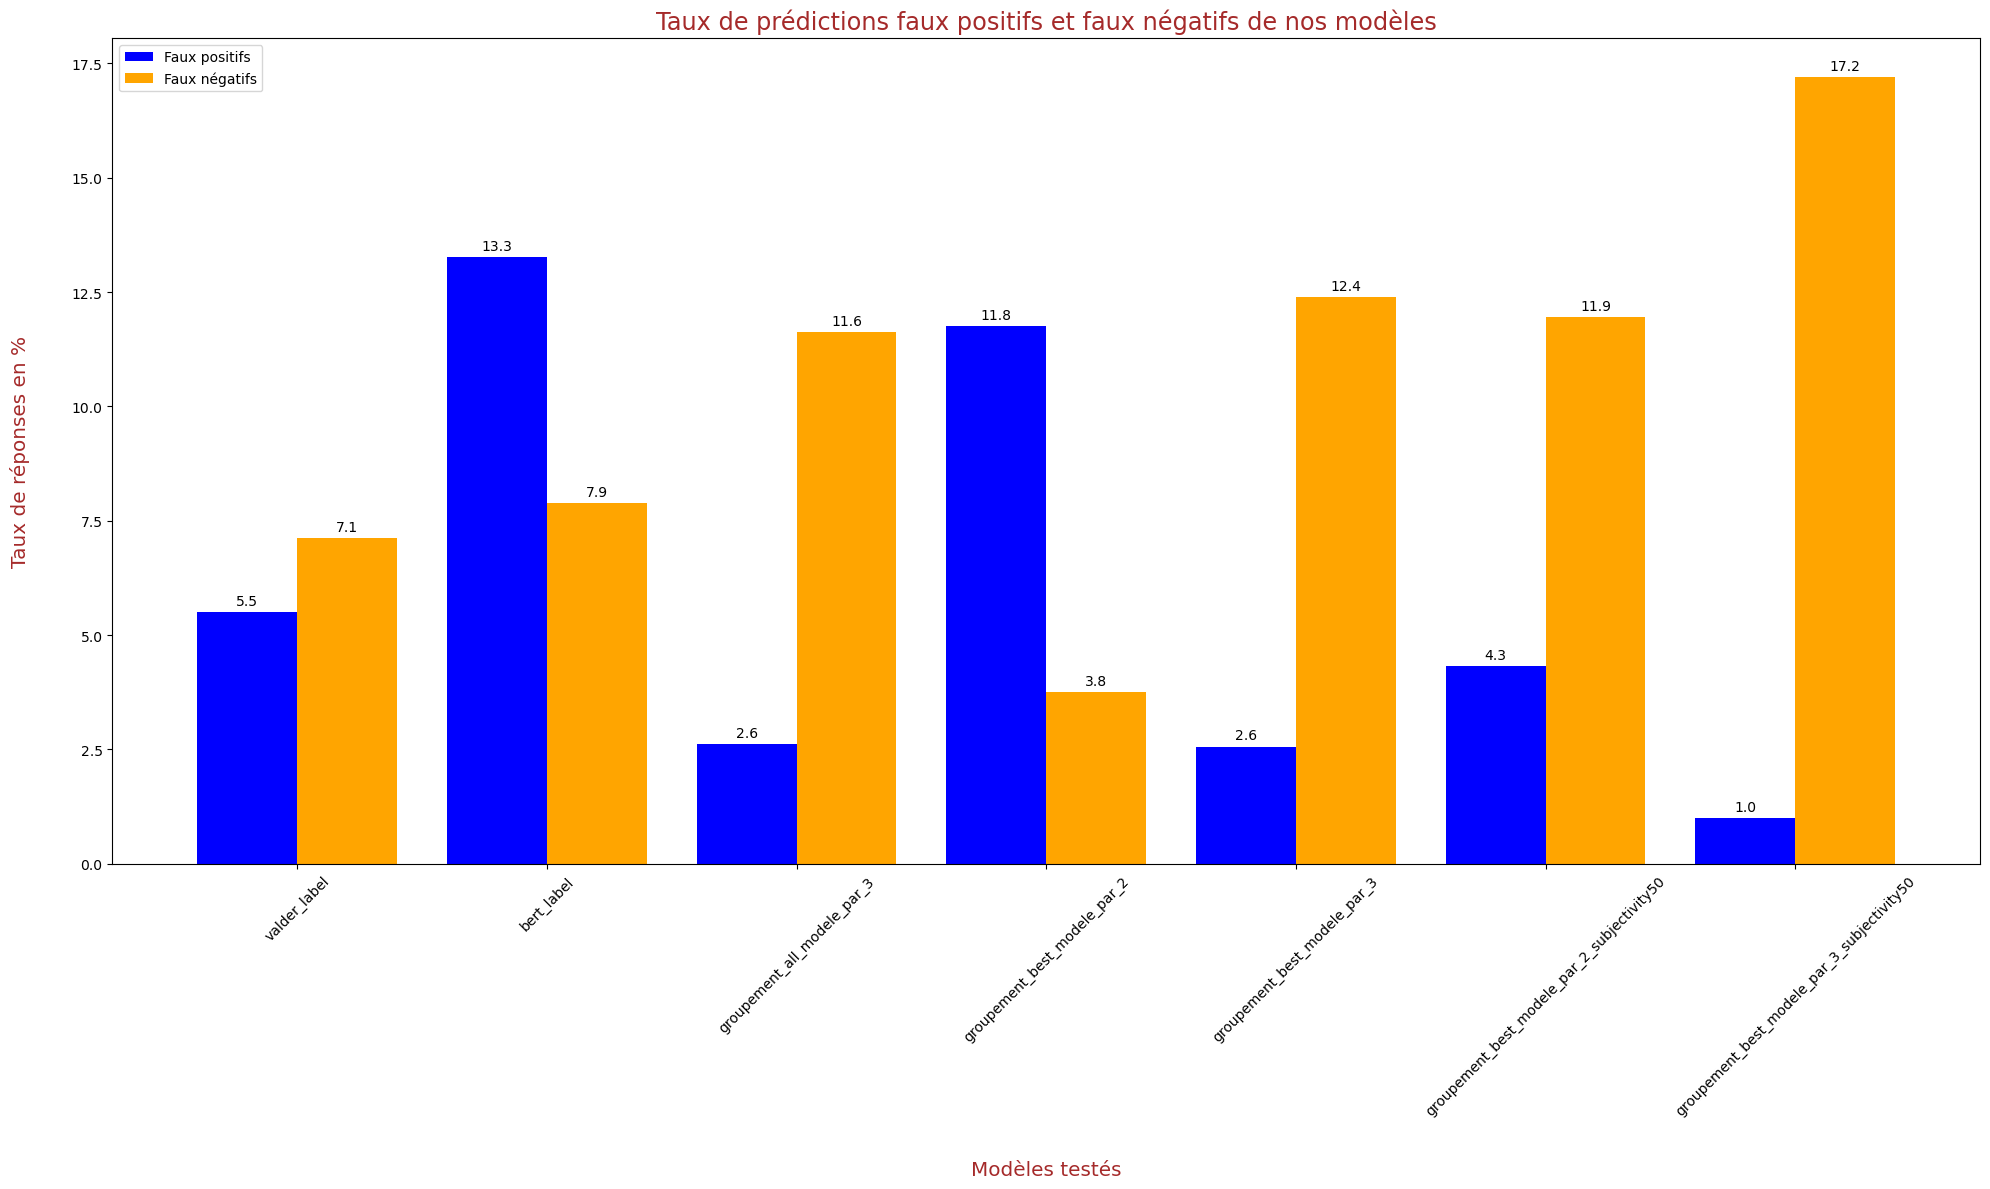

In [167]:
# Data avec des taux inférieurs à 20%
L_modeles2,L_matrices2,L_faux_pos2,L_faux_neg2 = Affinage(20)

# Create a new figure with specific size
fig = plt.figure(figsize=(20, 12))

# Create the first bar chart
bar1=plt.bar(L_modeles2, L_faux_pos2, width=-0.4, align='edge', color='b')

# Create the second bar chart
bar2=plt.bar(L_modeles2, L_faux_neg2, width=0.4, align='edge', color='orange')

# Add the legend
plt.legend(('Faux positifs', 'Faux négatifs'))
plt.xlabel('Modèles testés', size='x-large',color='brown', labelpad=30)
plt.ylabel('Taux de réponses en %', size='x-large', color='brown',labelpad=30)
plt.title('Taux de prédictions faux positifs et faux négatifs de nos modèles', size='xx-large', color='brown')
plt.xticks(rotation=45)

# Add value labels on the bar chart
for i, rect in enumerate(bar1 + bar2):
    height = rect.get_height()
    plt.annotate(f'{round(height,1)}',
                 xy=(rect.get_x() + rect.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# Show the plot
plt.tight_layout()
#plt.savefig('graph_resultats_modeles_affine.png')
plt.show()



Valder serait le meilleur modèle en regardant le taux combiné des faux positifs et faux négatifs, mais en privilégiant les faux positifs on pourrait envisager le modèle groupement_all_modele_par_3

# Graphs matrices de confusions

In [174]:
#Valder
matrix_valder = confusion_matrix(y_true=df['class'], y_pred=df['valder_label'])
matrix_valder = matrix_valder/(np.sum(matrix_valder))
df_matrix_valder = pd.DataFrame(matrix_valder, ['negatif','positif'], ['négatif','positif'])

#groupement_all_modele_par_3
matrix_g3 = confusion_matrix(y_true=df['class'], y_pred=df['groupement_all_modele_par_3'])
matrix_g3 = matrix_g3/(np.sum(matrix_g3))
df_matrix_g3 = pd.DataFrame(matrix_g3, ['negatif','positif'], ['négatif','positif'])

#groupement_best_modele_par_3
matrix_gb3 = confusion_matrix(y_true=df['class'], y_pred=df['groupement_best_modele_par_3'])
matrix_gb3 = matrix_gb3/(np.sum(matrix_gb3))
df_matrix_gb3 = pd.DataFrame(matrix_gb3, ['negatif','positif'], ['négatif','positif'])

#groupement_best_modele_par_3_subjectivity50
matrix_gb3_s50 = confusion_matrix(y_true=df['class'], y_pred=df['groupement_best_modele_par_3_subjectivity50'])
matrix_gb3_s50 = matrix_gb3_s50/(np.sum(matrix_gb3_s50))
df_matrix_gb3_s50 = pd.DataFrame(matrix_gb3_s50, ['negatif','positif'], ['négatif','positif'])

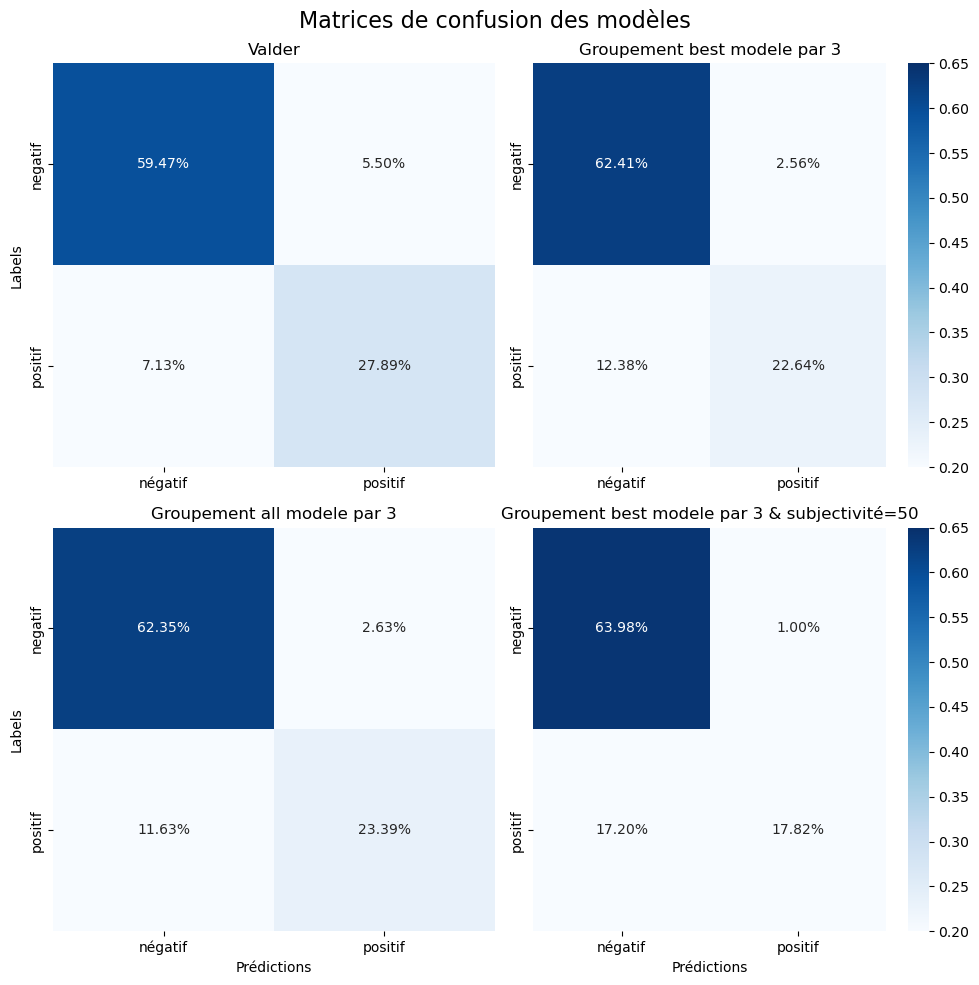

In [182]:
cmap=plt.cm.Blues

fig, axs = plt.subplots(2, 2 ,figsize=(10,10))
fig.suptitle('Matrices de confusion des modèles', fontsize=16)

#Valder
g1=sn.heatmap(df_matrix_valder, cmap=cmap, annot=True, fmt='.2%', cbar=False, vmin=0.2, vmax=0.65, ax=axs[0,0])
axs[0,0].set_title('Valder')
g1.set_ylabel('Labels')

#groupement_all_modele_par_3
g2=sn.heatmap(df_matrix_g3, cmap=cmap, annot=True, fmt='.2%',cbar=False, vmin=0.2, vmax=0.65, ax=axs[1,0])
axs[1,0].set_title('Groupement all modele par 3')
g2.set_xlabel('Prédictions')
g2.set_ylabel('Labels')

#groupement_best_modele_par_3
g3=sn.heatmap(df_matrix_gb3, cmap=cmap, annot=True, fmt='.2%', vmin=0.2, vmax=0.65, ax=axs[0,1])
axs[0,1].set_title('Groupement best modele par 3')
#g2.set_xlabel('Prédictions')
#g2.set_ylabel('Labels')

#groupement_best_modele_par_3_subjectivity50
g4=sn.heatmap(df_matrix_gb3_s50, cmap=cmap, annot=True, fmt='.2%', vmin=0.2, vmax=0.65, ax=axs[1,1])
axs[1,1].set_title('Groupement best modele par 3 & subjectivité=50')
g4.set_xlabel('Prédictions')
#g2.set_ylabel('Labels')

fig.tight_layout()
#plt.savefig('graph_matrices_de_confusion.png')
plt.show()


# Application du modèle

In [6]:
df_init=pd.read_csv(r'C:\Users\owen9\OneDrive\Documents\GitHub\TwitterFeelingAnalyse\Dataset\Tweepy_Suicide_Tweets.csv',sep=';')
df=df_init.copy()
df.head(10)

,id,text,auteur,date
0,1618391698639556610,@CDCDirector https://t.co/VgRPNEqwaN,813273195851681792,2023-01-25T23:33:43.000Z
1,1618391687990247424,RT @raphousetv2: I was today years old when I ...,808471634768265216,2023-01-25T23:33:41.000Z
2,1618391665726877697,"RT @shannonrwatts: Another day, another domest...",105294403,2023-01-25T23:33:36.000Z
3,1618391659888377856,RT @didphoebe: NO SHE DIDNT BUT WAITING ROOM T...,1332277646764482560,2023-01-25T23:33:34.000Z
4,1618391653571784704,@JJ_McCullough @washingtonpost Your effectivel...,29817415,2023-01-25T23:33:33.000Z
5,1618391651688534017,@foxnewspolitics Women do not commit suicide b...,1592315490256318466,2023-01-25T23:33:32.000Z
6,1618391651596267521,RT @SACHKAHOON: मां ने 18 महीने के बेटे की हत्...,1555056913272176641,2023-01-25T23:33:32.000Z
7,1618391647376793601,RT @worksfess: tw // mention of suicide - ngan...,78227605,2023-01-25T23:33:31.000Z
8,1618391624501055489,RT @rick_carp: This would shatter the male sui...,3185487954,2023-01-25T23:33:26.000Z
9,1618391619677589505,RT @JoeBell: Corporate suicide watch: Harley-D...,565959125,2023-01-25T23:33:25.000Z


In [14]:
df['text'] = df['text'].apply(lambda x: Cleaning(x))
df.head(10)

,id,text,auteur,date
0,1618391698639556610,https t co VgRPNEqwaN,813273195851681792,2023-01-25T23:33:43.000Z
1,1618391687990247424,RT I was today years old when I found out Ro...,808471634768265216,2023-01-25T23:33:41.000Z
2,1618391665726877697,RT Another day another domestic abuser in Am...,105294403,2023-01-25T23:33:36.000Z
3,1618391659888377856,RT NO SHE DIDNT BUT WAITING ROOM TAKEN OFF SP...,1332277646764482560,2023-01-25T23:33:34.000Z
4,1618391653571784704,Your effectively can t take away the right of ...,29817415,2023-01-25T23:33:33.000Z
5,1618391651688534017,Women do not commit suicide by shooting themse...,1592315490256318466,2023-01-25T23:33:32.000Z
6,1618391651596267521,RT 18 ...,1555056913272176641,2023-01-25T23:33:32.000Z
7,1618391647376793601,RT tw mention of suicide nganggur\n\nwor...,78227605,2023-01-25T23:33:31.000Z
8,1618391624501055489,RT This would shatter the male suicide epidem...,3185487954,2023-01-25T23:33:26.000Z
9,1618391619677589505,RT Corporate suicide watch Harley Davidson p...,565959125,2023-01-25T23:33:25.000Z


In [ ]:
df = AddAllModelToDF(df)
df = PreparationModel(df)

df["groupement_all_modele_par_3"] = np.where(df["modele_groupement_score"] >= 3, 1, 0)

df.head()